In [79]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
Slusarski


In [80]:
print(category_lines["Japanese"][0:5])

['Abe', 'Abukara', 'Adachi', 'Aida', 'Aihara']


In [81]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)


def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor


def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [82]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [83]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [87]:
input1 = lineToTensor('klbert')
input2 = lineToTensor('Albet')

hidden = torch.zeros(1, n_hidden)

output1, _ = rnn(input1[0], hidden)
output2, _ = rnn(input2[0], hidden)

print("Output for 'Albert':", output1)
print("Output for 'Albet':", output2)


Output for 'Albert': tensor([[-2.8933, -2.7550, -3.0085, -2.8801, -2.8942, -2.9283, -2.7255, -2.9484,
         -2.9160, -2.8309, -2.8822, -3.0429, -2.9857, -2.9525, -2.7263, -2.8982,
         -2.8885, -2.9381]], grad_fn=<LogSoftmaxBackward0>)
Output for 'Albet': tensor([[-2.9245, -2.7806, -2.9575, -2.8546, -2.8800, -2.9714, -2.6974, -2.8570,
         -3.0194, -2.8740, -2.8603, -3.0640, -3.0034, -2.8955, -2.8200, -2.8965,
         -2.8357, -2.9013]], grad_fn=<LogSoftmaxBackward0>)


In [88]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('German', 6)


In [89]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = German / line = Stroman
category = Irish / line = O'Toole
category = Dutch / line = Kools
category = Scottish / line = Alexander
category = Dutch / line = Silje
category = French / line = Samuel
category = Spanish / line = Avana
category = Italian / line = Lemmi
category = Italian / line = Zino
category = Irish / line = Maolmhuaidh


In [111]:
criterion = nn.NLLLoss()
optimizer=torch.optim.SGD(rnn.parameters(),lr=0.001)

In [112]:
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()  # Initialize hidden state

    optimizer.zero_grad()  # Zero the previous gradients

    # Loop through each character in the line tensor
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    # Calculate the loss
    loss = criterion(output, category_tensor)

    # Backpropagate the loss to compute gradients
    loss.backward()

    # Step through the optimizer to update the parameters
    optimizer.step()  # This updates the model's weights based on the gradients

    return output, loss.item()  # Return the model's output and the loss value


In [113]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 5s) 0.0130 Zhuan / Chinese ✓
10000 10% (0m 9s) 0.9922 Giugovaz / Italian ✓
15000 15% (0m 14s) 0.2943 Ahn / Korean ✓
20000 20% (0m 19s) 0.1462 Wendell / German ✓
25000 25% (0m 24s) 0.1138 Vega / Spanish ✓
30000 30% (0m 28s) 0.0829 Bosko / Polish ✓
35000 35% (0m 33s) 0.0354 Giang / Vietnamese ✓
40000 40% (0m 38s) 0.0503 Hajjar / Arabic ✓
45000 45% (0m 42s) 2.7672 Bernard / French ✗ (Polish)
50000 50% (0m 47s) 1.9132 Sappe / Dutch ✗ (Czech)
55000 55% (0m 52s) 0.0115 Ruzhitsky / Russian ✓
60000 60% (0m 56s) 1.8971 Eade / Irish ✗ (English)
65000 65% (1m 1s) 2.0482 Mata / Portuguese ✗ (Spanish)
70000 70% (1m 6s) 0.0271 Mcgregor / Scottish ✓
75000 75% (1m 11s) 1.3595 Lucas / English ✗ (Dutch)
80000 80% (1m 15s) 0.0501 Neri / Italian ✓
85000 85% (1m 20s) 0.0596 Dael / Dutch ✓
90000 90% (1m 25s) 0.0489 Adamsky / Russian ✓
95000 95% (1m 30s) 0.1556 Santiago / Portuguese ✓
100000 100% (1m 34s) 0.0002 Tupikov / Russian ✓


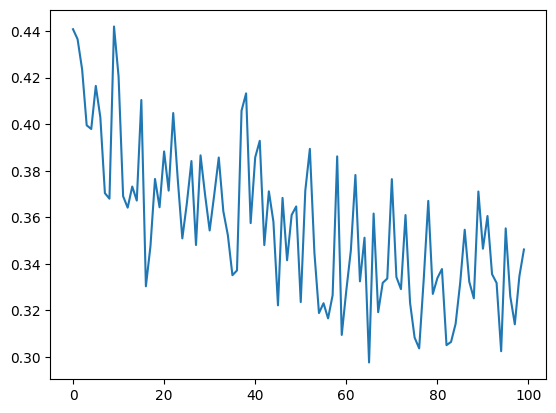

In [114]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)



C:\Users\austi\AppData\Local\Temp\ipykernel_13596\3585656379.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\austi\AppData\Local\Temp\ipykernel_13596\3585656379.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


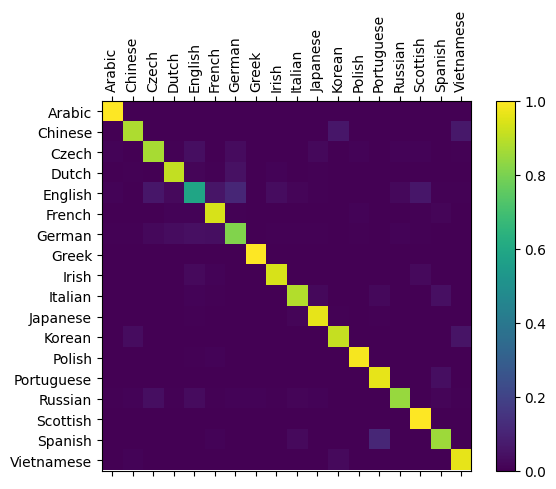

In [115]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [133]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('shadab')



> shadab
(-0.39) Arabic
(-2.02) Russian
(-2.82) Japanese
